<a href="https://colab.research.google.com/github/fredgi123/1-e-commerce-project/blob/main/2_testing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Mount Drive, import libraries and paths

In [ ]:
!git add .
!git commit -m "Add Colab notebook with LSTM implementation"


fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
#!git push https://<your-personal-access-token>@github.com/fredgi123/2_pricing_colab.git
!git remote add origin https://github.com/fredgi123/2_pricing_colab.git
!git branch -M main
!git push -u origin main

In [1]:
# ----------------------------------------
# 1. Mount Google Drive (if not already mounted)
# ----------------------------------------
from google.colab import drive
import os
import sys

mount_point = '/content/drive'

# Check if Drive is already mounted
if not os.path.exists(mount_point) or not os.listdir(mount_point):
    drive.mount(mount_point)
else:
    print(f'Drive already mounted at {mount_point}')


Mounted at /content/drive


In [67]:
# ----------------------------------------
# 2. Set Up Autoreload
# ----------------------------------------
%load_ext autoreload
%autoreload 2
print("Autoreload extension loaded and set to mode 2.")

# ----------------------------------------
# 2.1. Import Standard Libraries
# ----------------------------------------

# --- System and Utilities ---
import sys
import json
import random
import itertools
import re
import yaml
import pickle
import joblib
import itertools
import yaml
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

from datetime import datetime
import datetime as dt

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from PIL import Image as PILImage
from IPython.display import Image as DisplayImage, display
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import style

# --- Machine Learning and Deep Learning ---
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, RepeatVector, TimeDistributed, Dense


# ----------------------------------------
# 3. Define Paths and Add `scripts_p` to sys.path
# ----------------------------------------

# Define the path to your custom scripts
scripts_p = '/content/drive/MyDrive/1_Pricing/scripts'

# Add `scripts_p` to sys.path if not already added
if scripts_p not in sys.path:
    sys.path.append(scripts_p)
    print(f'Added Scripts Path to sys.path: {scripts_p}')
else:
    print(f'Scripts path already in sys.path: {scripts_p}')

# ----------------------------------------
# 4. Verify the Presence of `util_functions.py`
# ----------------------------------------
util_functions_path = os.path.join(scripts_p, "util_functions.py")
if not os.path.exists(util_functions_path):
    raise FileNotFoundError(f"'util_functions.py' not found in {scripts_p}")
else:
    print(f"'util_functions.py' found at {util_functions_path}")

# ----------------------------------------
# 5. Import Custom Modules Using importlib
# ----------------------------------------
import importlib.util

def load_module(module_name, module_path):
    """
    Load a module from a given file path using importlib.

    Args:
        module_name (str): The name to assign to the module.
        module_path (str): The file path to the module.

    Returns:
        module: The loaded module object, or None if failed.
    """
    spec = importlib.util.spec_from_file_location(module_name, module_path)
    if spec is None:
        print(f"Could not load spec for '{module_name}' at '{module_path}'.")
        return None
    module = importlib.util.module_from_spec(spec)
    try:
        spec.loader.exec_module(module)
        print(f"Module '{module_name}' loaded successfully.")
        return module
    except Exception as e:
        print(f"Failed to load module '{module_name}': {e}")
        return None

# Load all custom modules
util_functions = load_module("util_functions", util_functions_path)
util_functions_synthetic_data = load_module("util_functions_synthetic_data", os.path.join(scripts_p, "util_functions_synthetic_data.py"))
data_preprocessing = load_module("data_preprocessing", os.path.join(scripts_p, "data_preprocessing.py"))
training_baseline = load_module("training_baseline", os.path.join(scripts_p, "training_baseline.py"))
training_lstm = load_module("training_lstm", os.path.join(scripts_p, "training_lstm.py"))
training_xgboost = load_module("training_xgboost", os.path.join(scripts_p, "training_xgboost.py"))
training_prophet = load_module("training_prophet", os.path.join(scripts_p, "training_prophet.py"))
visualizations = load_module("visualizations", os.path.join(scripts_p, "visualizations.py"))
predict = load_module("predict", os.path.join(scripts_p, "predict.py"))

# Check if all modules are loaded
modules = [util_functions, util_functions_synthetic_data, data_preprocessing,
           training_baseline, training_lstm, training_xgboost, training_prophet, visualizations, predict]
for module in modules:
    if module is None:
        print("One or more modules failed to load. Please check the errors above.")

# ----------------------------------------
# 6. Define and Assign Directory Paths
# ----------------------------------------

# Define directory structure
directory_structure = {
    "data": {
        "synthetic_data": {},
        "raw_data": {},
        "intermediate_data": {}
    },
    "models": {
        "temp": {},
        "prophet": {},
        "lstm": {},
        "xgboost": {}
    },
    "notebooks": {},
    "config": {},        # Added config directory
    "dict": {},
    "predictions": {},
    "results": {},
    "scripts": {},
    "env": {},
    "static": {
        "images": {},
        "videos": {}
    },
    "temp": {}
}


default_dict_p = '/content/drive/MyDrive/1_Pricing/dict'

# Use the `create_paths` function from `util_functions_synthetic_data` module
if util_functions_synthetic_data and hasattr(util_functions_synthetic_data, 'create_paths'):
    loaded_paths = util_functions_synthetic_data.create_paths(default_dict_p, directory_structure, imports=False)
    print("Paths created successfully.")
else:
    raise AttributeError("util_functions_synthetic_data module does not have 'create_paths' function or is not loaded.")

# Assign directory paths
dict_p = loaded_paths.get('dict_p')
images_p = loaded_paths.get('images_p')
raw_data_p = loaded_paths.get('raw_data_p')
results_p = loaded_paths.get('results_p')
synthetic_data_p = loaded_paths.get('synthetic_data_p')
scripts_p = loaded_paths.get('scripts_p')
predictions_p = loaded_paths.get('predictions_p')
models_p = loaded_paths.get('models_p')
static_p = loaded_paths.get('static_p')
videos_p = loaded_paths.get('videos_p')
env_p = loaded_paths.get('env_p')
notebooks_p = loaded_paths.get('notebooks_p')
intermediate_p = loaded_paths.get('intermediate_data_p')
temp_p = loaded_paths.get('temp_p')
prophet_p = loaded_paths.get('prophet_p')
lstm_p = loaded_paths.get('lstm_p')
xgboost_p = loaded_paths.get('xgboost_p')
config_p = loaded_paths.get('config_p')

categorie = "soap"
categorie_path = os.path.join(synthetic_data_p, categorie)

print("Paths assigned successfully.")

# ----------------------------------------
# 7. Restore the Original Working Directory
# ----------------------------------------
original_cwd = '/content/drive/MyDrive/1_Pricing/notebooks'  # Ensure this is your intended directory
os.chdir(original_cwd)
print(f"Working directory restored to: {os.getcwd()}")

# ----------------------------------------
# 8. Utilize Imported Modules
# ----------------------------------------

# Example usage of util_functions
if util_functions:
    print("\nFunctions available in 'util_functions':")
    print(dir(util_functions))  # List available functions and attributes

    # Example: Using a function from util_functions
    if hasattr(util_functions, 'save_config'):
        print("\n'save_config' function is available.")
        # Example usage:
        # config = {'key': 'value'}
        # util_functions.save_config(config, 'config.yaml')
    else:
        print("\n'save_config' function is NOT available in 'util_functions'.")
else:
    print("util_functions module is not loaded.")
from data_preprocessing import *
from training_baseline import *
from training_lstm import *
from training_xgboost import *
from training_prophet import *
from visualizations import *
from predict import *
from util_functions_training import *
from util_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Autoreload extension loaded and set to mode 2.
Scripts path already in sys.path: /content/drive/MyDrive/1_Pricing/scripts
'util_functions.py' found at /content/drive/MyDrive/1_Pricing/scripts/util_functions.py
Module 'util_functions' loaded successfully.
Module 'util_functions_synthetic_data' loaded successfully.
Module 'data_preprocessing' loaded successfully.
Module 'training_baseline' loaded successfully.
Module 'training_lstm' loaded successfully.
Module 'training_xgboost' loaded successfully.
Module 'training_prophet' loaded successfully.
Module 'visualizations' loaded successfully.
Module 'predict' loaded successfully.
Paths created successfully.
Paths assigned successfully.
Working directory restored to: /content/drive/MyDrive/1_Pricing/notebooks

Functions available in 'util_functions':
['MinMaxScaler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package

### 1. Define Variables and parameters

In [68]:
### 1. Define Variables and parameters
all_features = ["price", "display", "distribution", "mktg", "demand"]
num_products = 10  # Total number of products
half = num_products // 2  # Split point for 'our' and 'competitor' products

# Indices for 'our' and 'competitor' products for Move 1
our_idx = list(range(half))  # Indices for our products
comp_idx = list(range(half, num_products))  # Indices for competitor products
all_idx = list(range(num_products))

# Generate product names for Move 1
name_products = np.array([f"p{i}" for i in range(num_products)])
our_products = name_products[:half]  # Names of our products
comp_products = name_products[half:]  # Names of competitor products

array_3d, all_arrays, concatenated_arr, idx, number_idx = load_array(categorie_path,
                                                                   categorie, all_features, num_products)
original_index = idx.copy()
date_idx = pd.date_range(start=original_index[0], periods=num_weeks, freq="W")
date_idx = pd.to_datetime(date_idx)
num_weeks = len(idx)

all_features = ["price", "display", "distribution", "mktg", "demand"]
x_predictors = ["price", "display", "distribution", "mktg", "demand"]
y_target = ["price", "display", "distribution", "mktg", "demand"] ##### THIS CAN CHANGE ####
x_predictors_indices = [all_features.index(f) for f in x_predictors]
y_target_indices = [all_features.index(f) for f in y_target]

# all product 2d indices
x_all_indices = [all_features.index(feature) for feature in x_predictors]
y_all_indices = [all_features.index(feature) for feature in y_target]

def feature_product_indices(feature_list, num_products, predictors, p_index):
    # Find indices of the predictors in the feature list
    feature_indices = [feature_list.index(feature) for feature in predictors]
    return [(feature_index * num_products) + product_index
            for feature_index in feature_indices for product_index in p_index]
x_our_indices = feature_product_indices(all_features, num_products, x_predictors, our_idx)
x_comp_indices = feature_product_indices(all_features, num_products, x_predictors, comp_idx)
y_our_indices = feature_product_indices(all_features, num_products, y_target, our_idx)
y_comp_indices = feature_product_indices(all_features, num_products, y_target, comp_idx)
print(x_our_indices)

# Extract indices for predictors and target
x_predictors_indices = [all_features.index(f) for f in x_predictors]  # Extract indices for X predictors
y_target_indices = [all_features.index(f) for f in y_target]  # Extract indices for Y target
# Load array data
array_3d, all_arrays, concatenated_arr, idx, number_idx = load_array(categorie_path, categorie, all_features, num_products)
# Debug: Copy original index
original_index = idx.copy()

# Ensure the slicing uses the correct indices
x_arr_3d = array_3d[:, x_predictors_indices, :]  # Shape: (weeks, predictors, products)
y_arr_3d= array_3d[:, y_target_indices, :]  # Shape: (weeks, target, products)
x_arr_2d = x_arr_3d.reshape(x_arr_3d.shape[0], -1)  # Shape: (weeks, features * products)
y_arr_2d = y_arr_3d.reshape(y_arr_3d.shape[0], -1)  # Shape: (weeks, products)
full_arr2d = x_arr_2d.copy()
# Define necessary variables
price_idx = np.arange(num_products) + num_products * all_features.index("price")
demand_idx = np.arange(num_products) + num_products * all_features.index("demand")
price_arr = full_arr2d[:, price_idx]  # Select 'price' columns
demand_arr = full_arr2d[:, demand_idx]  # Select 'demand' columns

print(x_predictors_indices, y_target_indices)
col_names_x = [f"{f}_p{i}" for f in x_predictors for i in range(num_products)]
col_names_y = col_names_x.copy()
full_df_x = pd.DataFrame(x_arr_2d, columns=col_names_x, index=original_index )
full_df_y = full_df_x.copy()
full_df = full_df_x.copy()

full_df_x.to_excel("df_x.xlsx")
full_df_x.head()

[0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34, 40, 41, 42, 43, 44]
[0, 1, 2, 3, 4] [0, 1, 2, 3, 4]


,price_p0,price_p1,price_p2,price_p3,price_p4,price_p5,price_p6,price_p7,price_p8,price_p9,...,demand_p0,demand_p1,demand_p2,demand_p3,demand_p4,demand_p5,demand_p6,demand_p7,demand_p8,demand_p9
2022-01-09,3.500,3.500,2.967,3.049,3.213,3.406,2.795,2.904,3.017,3.315,...,3795.137593,3897.573831,2721.412036,3246.016427,2819.558733,3138.818655,3333.807231,3172.377772,3186.946030,2910.540548
2022-01-16,3.145,2.797,3.028,3.329,3.477,3.500,3.399,3.093,3.372,2.707,...,3139.400634,2748.386246,2894.553494,2912.403005,2916.956052,3002.680945,3412.300346,3246.961673,2937.174552,3468.882566
2022-01-23,2.679,2.736,2.971,3.500,2.786,3.500,2.521,2.460,3.296,3.500,...,3128.324890,2952.986081,2960.043836,2654.011692,2922.551797,2736.886246,3405.968017,3449.713625,2771.554815,3748.840359
2022-01-30,2.997,2.495,3.371,3.500,2.483,2.885,3.490,3.454,3.033,3.500,...,3121.880433,2932.341893,2991.586635,2818.072138,3403.635954,2932.202540,2996.326339,3721.493169,2857.950326,3430.717627
2022-02-06,2.744,3.060,3.445,3.122,3.129,2.768,3.500,3.291,3.130,2.949,...,3135.031426,2931.066065,3332.853171,3073.463267,2802.465869,2812.223139,2979.184271,3439.945401,3209.851108,3262.003423


### 2. Check heteroscedasticity

In [69]:
heteroscedasticity_results = check_heteroscedasticity(concatenated_arr = full_arr2d, all_features=all_features, num_products=num_products, method="both")
# Print Summary full_df_x.head()

if heteroscedasticity_results["heteroscedasticity_detected"]:
    print("Heteroscedasticity detected in the dataset.")
else:
    print("No significant heteroscedasticity detected.")
# Detailed Results
print(heteroscedasticity_results["results"])

Heteroscedasticity detected in the dataset.
{'product_0': {'breusch_pagan': False, 'rolling_std': True}, 'product_1': {'breusch_pagan': False, 'rolling_std': True}, 'product_2': {'breusch_pagan': False, 'rolling_std': True}, 'product_3': {'breusch_pagan': False, 'rolling_std': True}, 'product_4': {'breusch_pagan': False, 'rolling_std': True}, 'product_5': {'breusch_pagan': False, 'rolling_std': True}, 'product_6': {'breusch_pagan': False, 'rolling_std': True}, 'product_7': {'breusch_pagan': False, 'rolling_std': True}, 'product_8': {'breusch_pagan': False, 'rolling_std': True}, 'product_9': {'breusch_pagan': False, 'rolling_std': True}}


### 3. Preprocess_demand_price_data

Saved processed data to /content/drive/MyDrive/1_Pricing/temp/processed_data.xlsx
Saved individual plots to /content/drive/MyDrive/1_Pricing/temp/individual_plots.png


,demand_p0,demand_p1,demand_p2,demand_p3,demand_p4,demand_p5,demand_p6,demand_p7,demand_p8,demand_p9,...,value_p0,value_p1,value_p2,value_p3,value_p4,value_p5,value_p6,value_p7,value_p8,value_p9
date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,13184.743550,12531.288051,11567.596001,11630.503262,12062.702537,11810.588386,13148.401932,13590.546239,11753.625722,13558.981100,...,40893.454608,36724.307678,35718.066275,38744.787094,35794.955784,39238.705836,39960.024379,40595.770428,37322.376769,44167.159972
2022-02-28,12696.954207,12652.817568,12654.146068,12998.470985,11719.013187,12676.335558,13488.303535,12872.321822,12588.107489,12553.172542,...,39432.362107,39920.906816,42648.400157,42328.377544,37741.387075,39717.966506,42088.352730,40301.591467,41264.181366,40802.702292
2022-03-31,14291.589562,13792.756255,14127.893607,13831.146325,12912.933516,15355.121972,13616.664816,13542.716421,13512.487291,13708.494858,...,44297.074612,40992.906056,43786.792773,41433.662945,43090.690780,47830.257830,43215.257864,44206.720359,42855.035926,45933.524626
2022-04-30,12507.806784,13548.686717,15959.556484,14554.038570,15714.399215,13732.407415,14819.386760,15791.563424,17260.882688,15122.210199,...,39356.744815,43205.419919,45120.977243,44982.853413,46462.311884,39063.504389,40317.218552,45867.691491,55445.740889,49274.025927
2022-05-31,17605.913983,16953.600740,20530.027663,17217.697399,18802.208401,20357.813877,17907.230341,18553.813817,19253.667380,18703.132176,...,49966.860197,54935.087297,62890.859346,55863.921967,51822.058742,64264.054476,55229.998135,58710.055945,57497.927353,56060.778737


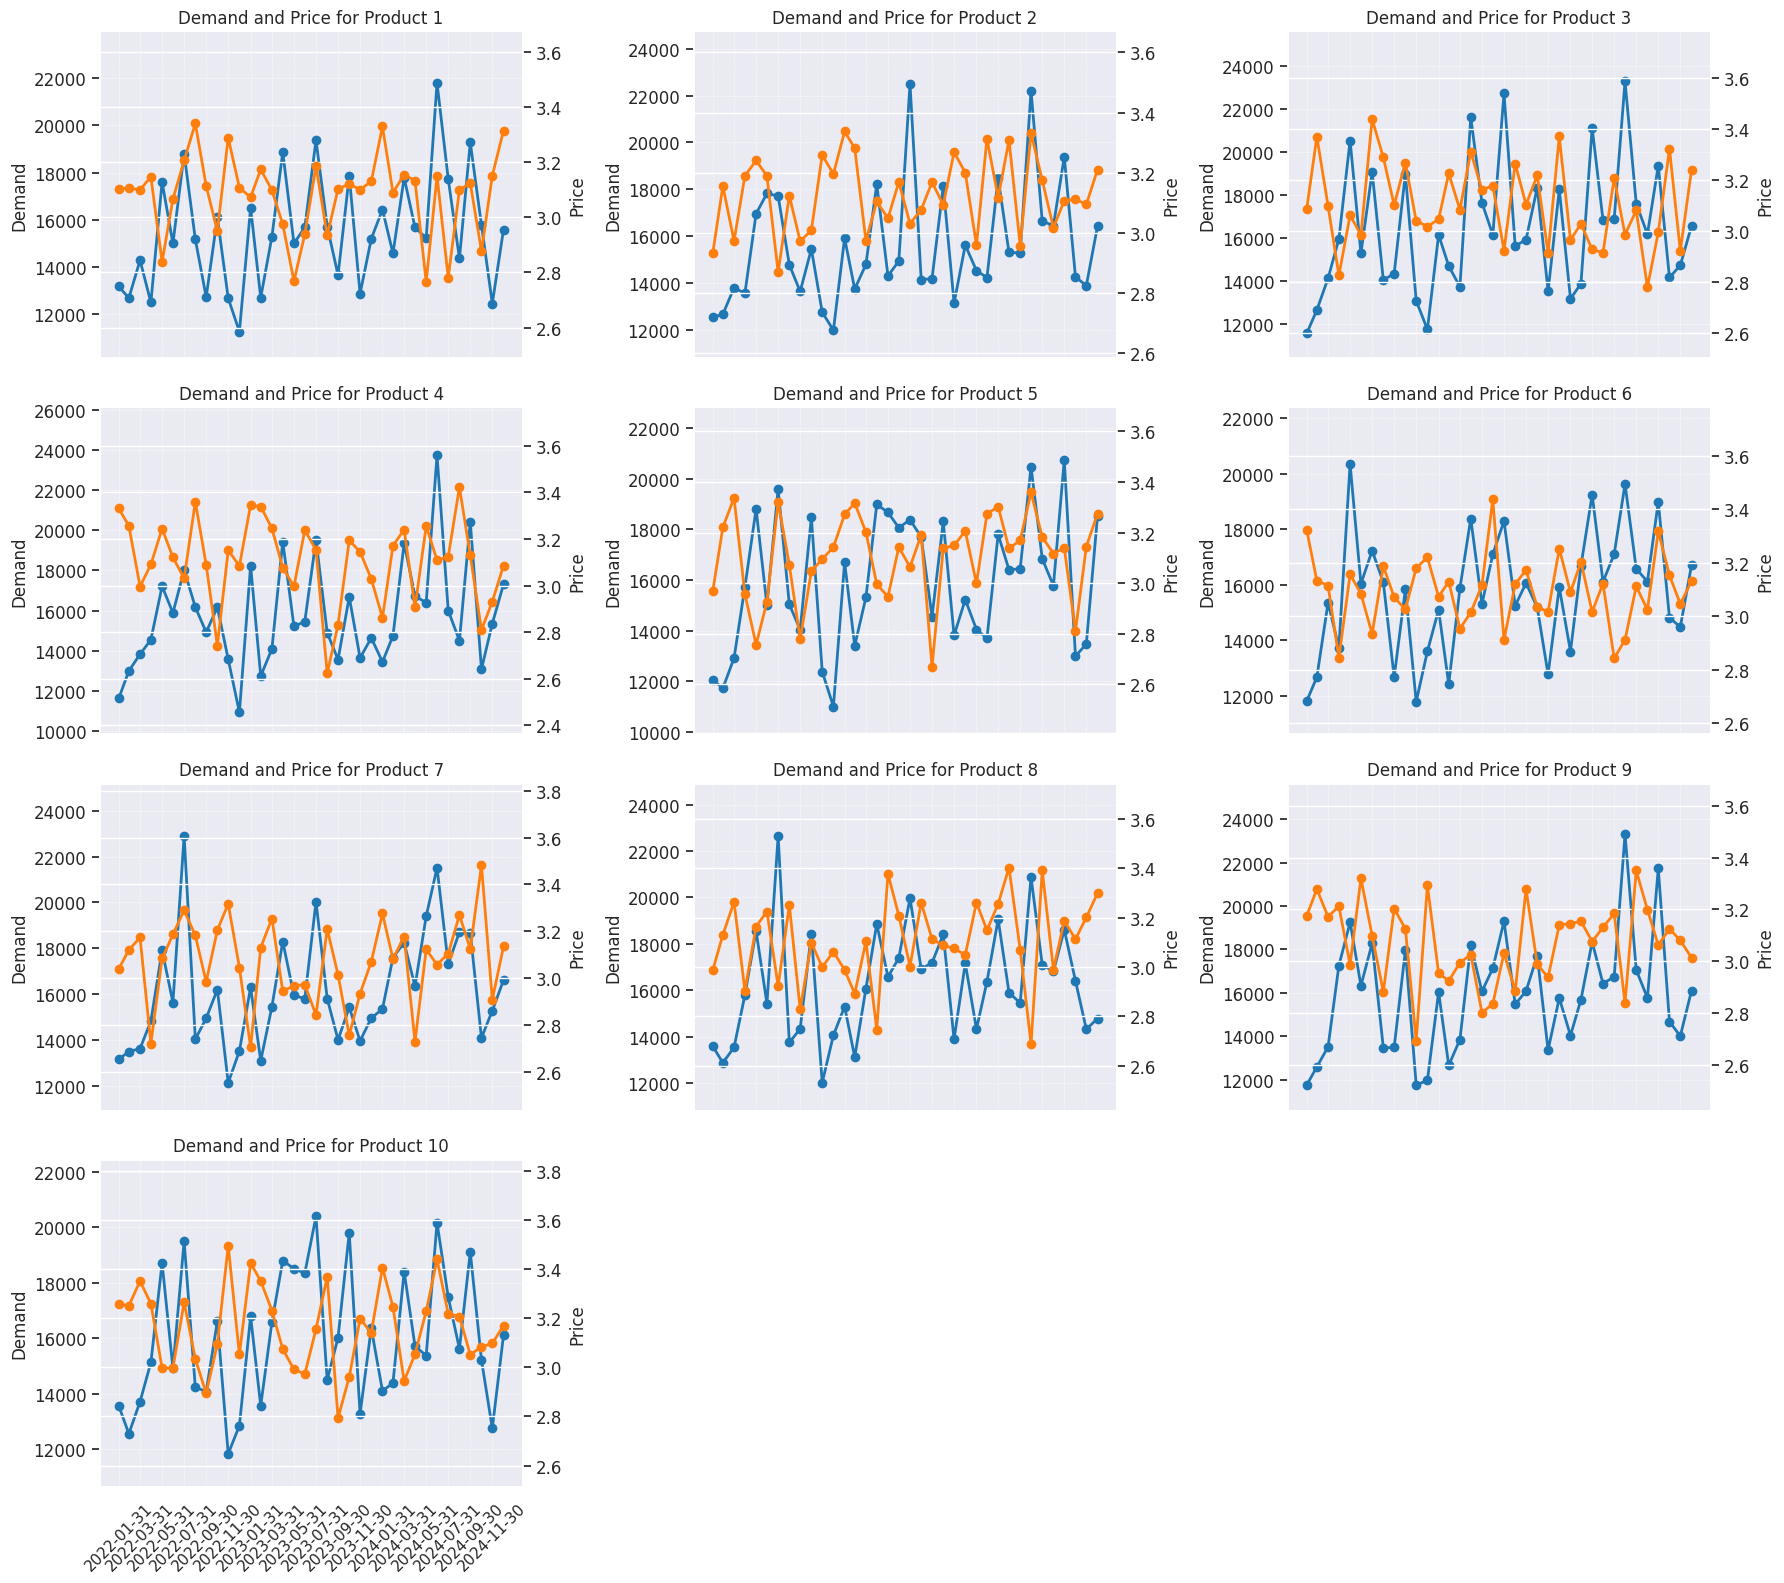

In [70]:
df_processed = preprocess_demand_price_data(demand_arr=demand_arr, price_arr=price_arr,
    date_idx= date_idx, resample= True,aggregate = False,temp_p= temp_p)

fig = plot_demand_price_data(df=df_processed, aggregate = False,  # Set to False for individual plots
    temp_p= temp_p, y_axis_min_perc=0.9,y_axis_max_perc=1.1,max_x_ticks=15,aggregate_font_size=16,individual_font_size=12,line_width=2.0)
# plt.show()
df_processed.head()

### 4. Deseasonalize with Prophet

/content/drive/MyDrive/1_Pricing/scripts/predict.py:113: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast["ds"].isin(idx)]
/content/drive/MyDrive/1_Pricing/scripts/predict.py:113: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast = forecast[forecast["ds"].isin(idx)]
/content/drive/MyDrive/1_Pricing/scripts/predict.py:113: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before

Testing if restored_data close to original demand:  True


/content/drive/MyDrive/1_Pricing/scripts/visualizations.py:254: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/content/drive/MyDrive/1_Pricing/scripts/visualizations.py:254: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


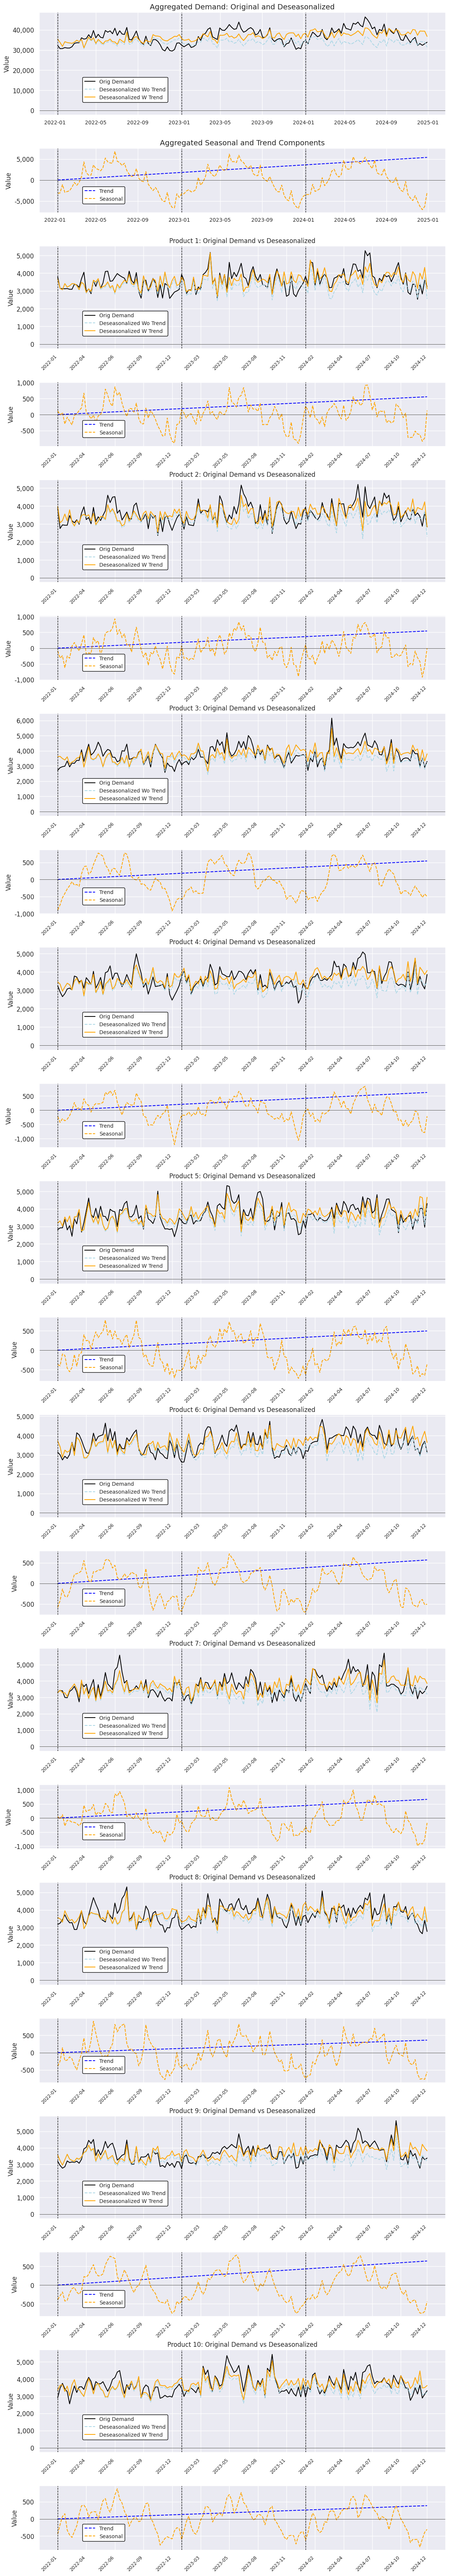

,price_p0,price_p1,price_p2,price_p3,price_p4,price_p5,price_p6,price_p7,price_p8,price_p9,...,demand_p0,demand_p1,demand_p2,demand_p3,demand_p4,demand_p5,demand_p6,demand_p7,demand_p8,demand_p9
2022-01-09,3.500,3.500,2.967,3.049,3.213,3.406,2.795,2.904,3.017,3.315,...,3680.084808,3983.555381,3618.284731,3458.041185,3188.047675,3722.059356,3280.292609,3565.055560,3573.522622,3349.316428
2022-01-16,3.145,2.797,3.028,3.329,3.477,3.500,3.399,3.093,3.372,2.707,...,3147.940516,3066.364227,3640.134625,3340.009735,3318.898164,3420.637661,3448.607547,3497.654403,3221.772956,3634.109998
2022-01-23,2.679,2.736,2.971,3.500,2.786,3.500,2.521,2.460,3.296,3.500,...,3062.888923,3191.461199,3496.087418,2951.156669,3019.737770,2873.039569,3283.859734,3307.720814,2955.921668,3676.252699
2022-01-30,2.997,2.495,3.371,3.500,2.483,2.885,3.490,3.454,3.033,3.500,...,3414.666660,3558.250640,3402.493497,3187.205965,3536.456763,3245.639235,3280.949367,3955.294581,3284.363779,3279.286845
2022-02-06,2.744,3.060,3.445,3.122,3.129,2.768,3.500,3.291,3.130,2.949,...,3215.476298,3180.488836,3610.621462,3387.954715,3266.143999,3139.295018,3055.682794,3654.510447,3614.665867,3589.074320


In [71]:
# Call the function
output_deseasonalize = train_deseasonalize_with_prophet(data = demand_arr,
                                                        idx= date_idx,
                                                        category="soap",
                                                        model_p=prophet_p,
                                                        importation= True,  # Change to True if loading the model
                                                        model_file_name="prophet_model.pkl",
                                                        aggregated=False) # Set to True for aggregated model, individual model is best
baseline_w_trend = output_deseasonalize[0]
components_list = output_deseasonalize[1]
models_list = output_deseasonalize[2]
components_df = output_deseasonalize[4]

restored_data = add_seasonality(original_index = original_index,
                                current_idx = idx,
                                array = baseline_w_trend,
                                prophet_model_list = models_list)

close_to_zero = np.allclose(restored_data, demand_arr, atol=1e-5)
print("Testing if restored_data close to original demand: ", close_to_zero)

fig = plot_demand_components(components_list, date_idx) # to plot visualizations
# fig.savefig("aggregated_and_individual_demand_components.png")
plt.show()

# important, array will be use for predictions
full_arr2d_deseas, df_full_deseas = deseasonalize_demand_array(full_arr2d, baseline_w_trend,
                                                               num_products, all_features, date_idx)

df_full_deseas.head()

### 4. Log and normalize data

In [81]:
config_file_path = os.path.join(config_p, 'lstm_move1_config.yml')
with open(config_file_path, 'r') as file:
    config_lstm_move1 = yaml.safe_load(file)


# Move 1 Predictors and Target
m1_x_predictors = ["price", "display", "distribution", "mktg", "demand"]
m1_y_target = ["price", "display", "distribution", "mktg"]

# Access configurations for Move 1
m1_baseline_hyperparams = config_lstm_move1['model']
m1_back_windows = config_lstm_move1['training']['back_windows']
m1_prediction_steps = config_lstm_move1['training']['prediction_steps']
m1_test_len = config_lstm_move1['training']['test_len']
m1_x_apply_lag = config_lstm_move1['data']['x_apply_lag']
m1_num_products = config_lstm_move1['data']['num_products']

# Path and Taxonomy for Move 1
m1_lstm_p_path = lstm_p
m1_taxonomy_name = 'move1_competitor_action_prediction'

# Corrected way to count total features for Move 1
m1_total_features = sum(len(v) for v in m1_x_apply_lag.values()) * m1_num_products
m1_y_total_features = len(m1_y_target) * len(comp_idx)

print("Total X features for Move 1:", m1_total_features)
print("Total Y features for Move 1:", m1_y_total_features)

# Call the function for Move 1
m1_best_model, m1_best_params = train_competitor_action_prediction_model(
    df_full_deseas = df_full_deseas,
    x_apply_lag = m1_x_apply_lag,
    x_predictors = m1_x_predictors,
    y_target = m1_y_target,
    x_product_indices = all_idx,
    y_product_indices = comp_idx,
    test_len = m1_test_len,
    baseline_hyperparams = m1_baseline_hyperparams,
    back_windows = m1_back_windows,
    prediction_steps = m1_prediction_steps,
    lstm_p_path = m1_lstm_p_path,
    taxonomy_name = m1_taxonomy_name,
    importation = True  # Set to False to train the model
)


# Print the best parameters
print("Best Hyperparameters and Parameters:")
for key, value in m1_best_params.items():
    print(f"{key}: {value}")

print(m1_best_params)
print(m1_best_model.summary())

Total X features for Move 1: 150
Total Y features for Move 1: 20
Loaded best model from /content/drive/MyDrive/1_Pricing/models/lstm/move1_competitor_action_prediction_best_model.keras
Loaded best parameters from /content/drive/MyDrive/1_Pricing/models/lstm/move1_competitor_action_prediction_best_params.json
Best Hyperparameters and Parameters:
num_lstm_layers: 1
num_units: 64
dropout_rate: 0.2
recurrent_dropout: 0.2
optimizer: adam
learning_rate: 0.001
epochs: 100
batch_size: 32
back_window_size: 8
prediction_step_size: 4
best_score: 0.0640866357174313
{'num_lstm_layers': 1, 'num_units': 64, 'dropout_rate': 0.2, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'back_window_size': 8, 'prediction_step_size': 4, 'best_score': 0.0640866357174313}


Model: "sequential_489"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_716 (LSTM)                      │ (None, 64)                  │          55,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_366 (RepeatVector)     │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_717 (LSTM)                      │ (None, 4, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_470                 │ (None, 4, 20)               │           1,300 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,094 (1.02 MB)

 Trainable params: 89,364 (349.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 178,730 (698.17 KB)

None


In [ ]:
### MAKE PREDICTIONS NOW

/content/drive/MyDrive/1_Pricing/config


Loaded best model from /content/drive/MyDrive/1_Pricing/models/lstm/move1_competitor_action_prediction_best_model.keras
Loaded best parameters from /content/drive/MyDrive/1_Pricing/models/lstm/move1_competitor_action_prediction_best_params.json
4 119 155
Start DataFrame shape: (115, 50)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Shape of Y_pred_scaled: (103, 4, 20)
Shape of Y_pred_flat: (103, 20)
Predictions saved to /content/drive/MyDrive/1_Pricing/temp/move1_competitor_action_prediction_predictions.csv
[5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39]
start prediction arr shape (125, 50) gliding array shape (129, 50) step prediction array (4, 50)
            price_p5  price_p6  price_p7  price_p8  price_p9  display_p5  \
2022-05-01  3.291519  3.364469  3.267009  3.260702  3.383977    8.555737   
2022-05-08  3.250672  3.336972  3.295802  3.250144  3.358608    7.319165   
2022-05-15  3.232510  3.348282  3.239580  3.295700  3.373812    5.331237   
2022-05-22  3.219

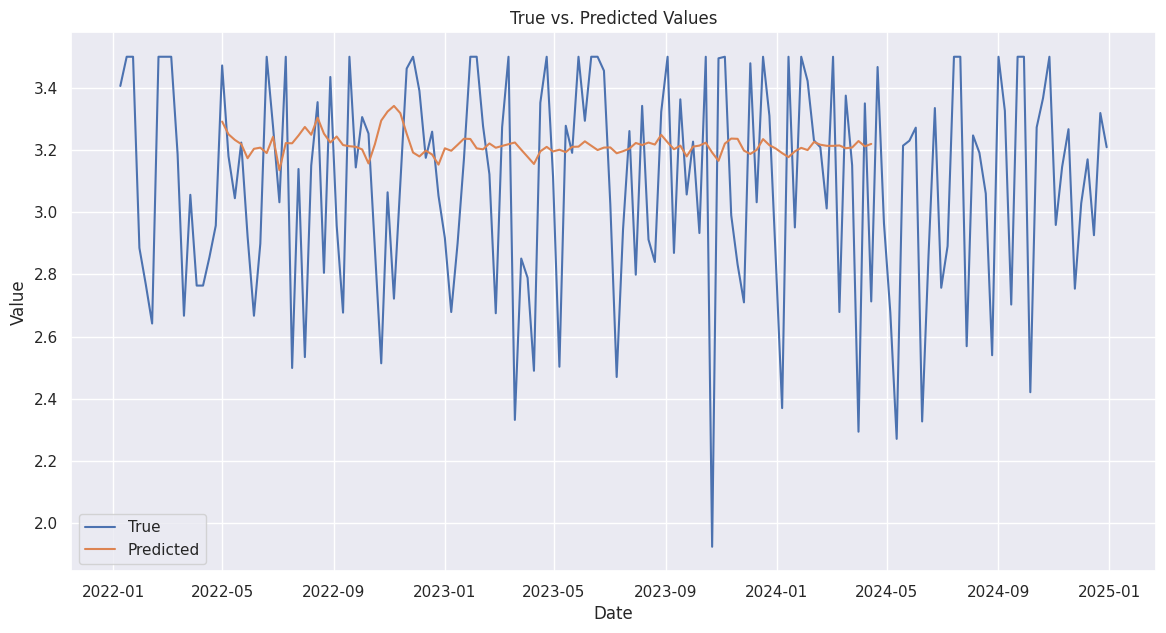

In [103]:
# Load the best model and scalers
m1_best_model, m1_best_params = load_best_lstm_model(lstm_p_path, taxonomy_name=taxonomy_name)
# Define scaler paths
X_scaler_path = os.path.join(lstm_p, f'X_scaler_{taxonomy_name}.save')
Y_scaler_path = os.path.join(lstm_p, f'Y_scaler_{taxonomy_name}.save')

# Store the paths in the best_params dictionary
m1_best_params['scalers'] = {'X_scaler': X_scaler_path, 'Y_scaler': Y_scaler_path}

def generate_prediction_sequences(X, back_window_size):
    X_sequences = [
        X[i : i + back_window_size]
        for i in range(len(X) - back_window_size + 1)
    ]
    return np.array(X_sequences)

def make_predictions(
    df_full_deseas,
    x_apply_lag,
    x_predictors,
    y_target,
    x_product_indices,
    y_product_indices,
    best_model,
    best_params,
    lstm_p_path,
    taxonomy_name,
    temp_p
):
    # Extract parameters
    back_window_size = best_params['back_window_size']
    prediction_step_size = best_params['prediction_step_size']

    # Prepare column names for predictors
    col_names_x = [f"{feature}_p{product_idx}" for feature in x_predictors for product_idx in x_product_indices]

    # Slice predictors from the deseasonalized DataFrame
    sliced_df_x = df_full_deseas[col_names_x]

    # Apply lagged features
    max_lag = max([max(lags) for lags in x_apply_lag.values()])
    lagged_df_x = apply_lagged_features_df(df=sliced_df_x, x_apply_lag=x_apply_lag)

    # Convert to numpy array
    X_full = lagged_df_x.values

    # Load scalers from best_params
    scaler_paths = best_params.get('scalers', {})
    if 'X_scaler' in scaler_paths and 'Y_scaler' in scaler_paths:
        X_scaler = load(scaler_paths['X_scaler'])
        Y_scaler = load(scaler_paths['Y_scaler'])
    else:
        raise ValueError("Scalers not found in best_params. Ensure they were saved correctly.")

    # Scale predictors
    X_full_scaled = X_scaler.transform(X_full)

    # Generate prediction sequences
    X_full_seq = generate_prediction_sequences(X_full_scaled, back_window_size)

    # Perform predictions
    Y_pred_scaled = best_model.predict(X_full_seq)
    print(f"Shape of Y_pred_scaled: {Y_pred_scaled.shape}")

    # Reshape predictions and inverse scale
    Y_pred_scaled_flat = Y_pred_scaled[:, -1, :]
    Y_pred_flat = Y_scaler.inverse_transform(Y_pred_scaled_flat)
    print(f"Shape of Y_pred_flat: {Y_pred_flat.shape}")

    # Correct prediction date range calculation
    prediction_start = len(df_full_deseas) - len(Y_pred_flat)
    prediction_dates = df_full_deseas.index[prediction_start:]

    # Validate index alignment
    if len(prediction_dates) != len(Y_pred_flat):
        raise ValueError(
            f"Index mismatch: prediction_dates length {len(prediction_dates)} "
            f"does not match predictions length {len(Y_pred_flat)}."
        )

    # Create DataFrame for predictions
    pred_columns = [f"{feature}_p{product_idx}" for feature in y_target for product_idx in y_product_indices]
    predictions_df = pd.DataFrame(Y_pred_flat, columns=pred_columns, index=prediction_dates)

    # Save predictions
    predictions_filepath = os.path.join(temp_p, f"{taxonomy_name}_predictions.csv")
    predictions_df.to_csv(predictions_filepath, index=True)

    print(f"Predictions saved to {predictions_filepath}")
    return predictions_df, predictions_df.iloc[-prediction_step_size:]

    return predictions_df, predictions_df.tail(prediction_step_size)



# Load configurations from config file
config_file_path = os.path.join(config_p, 'lstm_move1_config.yml')
with open(config_file_path, 'r') as file:
    config_lstm_move1 = yaml.safe_load(file)

# Access configurations
m1_baseline_hyperparams = config_lstm_move1['model']
m1_back_windows = config_lstm_move1['training']['back_windows']
m1_prediction_steps = config_lstm_move1['training']['prediction_steps']
m1_test_len = config_lstm_move1['training']['test_len']
m1_x_apply_lag = config_lstm_move1['data']['x_apply_lag']
m1_x_predictors = config_lstm_move1['data']['x_predictors']
m1_y_target = config_lstm_move1['data']['y_target']

# Determine the cut-off range for prediction
cut_off = m1_test_len  # This can be adjusted as needed
back_window = m1_best_params["back_window_size"]

# Calculate the start and end indices for the prediction array
start_index = m1_prediction_steps # len(full_arr2d_deseas) - cut_off - back_window -1
end_index = len(full_arr2d_deseas) - cut_off -1
print(start_index, end_index,  end_index + cut_off)


# Slice the DataFrame for predictions
start_df = df_full_deseas.iloc[start_index:end_index]
print(f"Start DataFrame shape: {start_df.shape}")

# Make predictions
predictions_df, latest_predictions = make_predictions(
    df_full_deseas=start_df,
    x_apply_lag=m1_x_apply_lag,
    x_predictors=m1_x_predictors,
    y_target=m1_y_target,
    x_product_indices=all_idx,
    y_product_indices=comp_idx,
    best_model=m1_best_model,
    best_params=m1_best_params,
    lstm_p_path=lstm_p,
    taxonomy_name=m1_taxonomy_name,
    temp_p=temp_p
)

def feature_product_indices(feature_list, num_products, predictors, p_index):
    # Find indices of the predictors in the feature list
    feature_indices = [feature_list.index(feature) for feature in predictors]
    return [(feature_index * num_products) + product_index
            for feature_index in feature_indices for product_index in p_index]
m1_indices = feature_product_indices(all_features, num_products, m1_y_target, comp_idx)
step_prediction_array = np.zeros((m1_prediction_steps, num_products * len(all_features)))
step_prediction_array[:,m1_indices] = latest_predictions.values
gliding_array = np.vstack((start_df.values, step_prediction_array))
print("start prediction arr shape", start_df.shape, "gliding array shape",
      gliding_array.shape, "step prediction array",step_prediction_array.shape)



# Display the predictions DataFrame
print(predictions_df)

# Plotting predictions vs true values for a specific target
plt.figure(figsize=(14, 7))

# Select a specific target to plot, e.g., the first target
target_col = predictions_df.columns[0]
plt.plot(df_full_deseas.index, df_full_deseas[target_col], label='True')
plt.plot(predictions_df.index, predictions_df[target_col], label='Predicted')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()


In [ ]:
###### STOPS HERE ##############


Total Samples: 158

|<--- Training Set (126) --->|<-- Validation Set (16) -->|<-- Test Set (16) -->|

Training Effective Samples: 115
Validation Effective Samples: 5
Test Effective Samples: 5


In [ ]:
print(best_params)

NameError: name 'best_params' is not defined

In [ ]:
def inverse_transform(predictions, y_scaler, original_index, current_idx, prophet_model_list=None):
    """
    Reverse MinMax scaling, log transformation, and optionally add seasonality back to predictions.

    Args:
        predictions (np.ndarray): Scaled predictions (shape: weeks x num_products).
        y_scaler (MinMaxScaler): Fitted MinMaxScaler for the target variable.
        original_index (list or pd.DatetimeIndex): Original date index before transformations.
        current_idx (list or pd.DatetimeIndex): Current date index for predictions.
        prophet_model_list (list): List of Prophet models for re-adding seasonality (optional).

    Returns:
        restored_predictions (np.ndarray): Predictions with scaling, log transformation,
                                           and optionally seasonality reversed.
    """
    # 1. Reverse MinMax scaling
    predictions_unscaled = y_scaler.inverse_transform(predictions)

    # 2. Reverse log transformation
    predictions_unlogged = np.expm1(predictions_unscaled)

    # 3. Add seasonality (if Prophet models are provided)
    if prophet_model_list is not None:
        restored_predictions = add_seasonality(
            original_index=original_index,
            current_idx=current_idx,
            array=predictions_unlogged,
            prophet_model_list=prophet_model_list
        )
    else:
        restored_predictions = predictions_unlogged

    return restored_predictions

# Assuming `predictions_scaled` is the LSTM prediction output (scaled and log-transformed)
predictions_original = inverse_transform(
    predictions=predictions_scaled,
    y_scaler=y_scaler,  # MinMaxScaler used during training
    original_index=original_index,  # Original date range
    current_idx=idx,  # Current date range (e.g., including forecasting horizon)
    prophet_model_list=models_list  # Prophet models used for seasonality
)


NameError: name 'predictions_scaled' is not defined

### 5. Train LSTM model

In [ ]:
print(y_arr_2d.shape)

(156, 10)


In [ ]:
# Sum of demand across products for each week
arr1 = y_arr_2d.sum(axis=1)  # Real values

# Initialize arrays for test and predictions
arr_2 = np.zeros(arr1.shape)  # Test values
sum_test_y = y_test.sum(axis=1)
arr_2[test_len: test_len + len(sum_test_y)] = sum_test_y

predictions = np.zeros(arr1.shape)  # Prediction values
sum_predictions = train_predictions_unscaled.sum(axis=1)
predictions[train_len: train_len+len(sum_predictions)] = sum_predictions

# Create a DataFrame with the date index and the three columns
df = pd.DataFrame({
    "Date": idx,  # Date index
    "Real": arr1,  # Column 1: Real values
    # "Test": arr_2,  # Column 2: Test values
    "Predictions": predictions  # Column 3: Predictions
})

# Set the date as the index
df.set_index("Date", inplace=True)

# Display the DataFrame
print(df)

# Optionally save to Excel
df.to_excel("demand_predictions.xlsx")
print("Data saved to 'demand_predictions.xlsx'")


                    Real  Predictions
Date                                 
2022-01-09  32222.188855          0.0
2022-01-16  30679.699514          0.0
2022-01-23  30730.881357          0.0
2022-01-30  31206.207054          0.0
2022-02-06  30978.087140          0.0
...                  ...          ...
2024-12-01  32229.782216          0.0
2024-12-08  33201.730077          0.0
2024-12-15  32331.369396          0.0
2024-12-22  33090.923065          0.0
2024-12-29  33852.872080          0.0

[156 rows x 2 columns]
Data saved to 'demand_predictions.xlsx'


In [ ]:
results
# Visualization and Evaluation
history_sum = results["train_y"].sum()
test_sum = results["test_y"].sum()
pred_sum = testPredict.sum(axis=1)

print(f"History Sum Shape: {history_sum.shape}, Test Sum Shape: {test_sum.shape}, Pred Sum Shape: {pred_sum.shape}")


History Sum Shape: (25,), Test Sum Shape: (1,), Pred Sum Shape: (1,)


In [ ]:
# Sequential Predictions (4 Weeks Step)
prediction_step_size = 4
forecast_horizon = 52  # Full horizon for comparison
gliding_3d_array = X_test_scaled.copy()  # Gliding window starts with test data
predictions_seq = []

for step in range(0, forecast_horizon, prediction_step_size):
    # Create sequences
    X_test_seq, _ = create_sequences(gliding_3d_array, Y_test_scaled, back_window, prediction_step_size)

    # Predict
    Y_pred_seq_scaled = model_52.predict(X_test_seq).reshape(-1, prediction_step_size, num_products)
    Y_pred_seq = y_scaler.inverse_transform(Y_pred_seq_scaled.reshape(-1, num_products))
    predictions_seq.append(Y_pred_seq)

    # Update the gliding array
    gliding_3d_array = np.vstack((gliding_3d_array[prediction_step_size:], Y_pred_seq_scaled[-1]))

# Combine Predictions
Y_pred_seq_full = np.concatenate(predictions_seq, axis=0)

# Evaluate RMSE
rmse_seq = calculate_rmse(Y_test[-forecast_horizon:], Y_pred_seq_full)
print(f"RMSE for 4-week sequential forecast: {rmse_seq}")

# Prepare DataFrame for Export
pred_seq_sum = Y_pred_seq_full.sum(axis=1)

df_seq = pd.DataFrame({
    "Date": idx,
    "History": np.concatenate([history_sum, [np.nan] * test_len]),
    "Test": np.concatenate([[np.nan] * len(history_sum), test_sum]),
    "Prediction (4 weeks)": np.concatenate([[np.nan] * (len(history_sum) + test_len - forecast_horizon), pred_seq_sum]),
}).set_index("Date")

# Export to Excel
df_seq.to_excel("predictions_4_week_steps.xlsx")


NameError: name 'model_52' is not defined

In [ ]:
# Plot History, Test, and Predictions (52-Week and 4-Week Steps)
plt.figure(figsize=(12, 6))
plt.plot(df_52.index, df_52["History"], label="History")
plt.plot(df_52.index, df_52["Test"], label="Test")
plt.plot(df_52.index, df_52["Prediction (52 weeks)"], label="Prediction (52 weeks)")
plt.plot(df_seq.index, df_seq["Prediction (4 weeks)"], label="Prediction (4 weeks)")
plt.legend()
plt.title("Weekly Demand: History, Test, Predictions")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.show()
